# Построение модели

In [1]:
import pandas as pd

data = pd.read_csv('data/processed/nnapartment_more_info_min.csv')

In [2]:
data.head()

,area1,district,building_type,year,price,rooms_count,no_first_no_last,area3_bins
0,44.0,Автозаводский район,кирпич,1961.0,4900000,2.0,False,1.0
1,32.0,Советский район,кирпич,1958.0,4000000,2.0,False,1.0
2,45.0,Канавинский район,кирпич,1972.0,4300000,2.0,True,1.0
3,30.8,Канавинский район,кирпич,1965.0,4200000,1.0,True,1.0
4,48.0,Московский район,панель,2016.0,7150000,2.0,True,1.0


Используем данные из набора, для создания интерфейса приложения (пока все переменные задаются в коде). Получим уникальные значения категориальных и границы числовых признаков.

In [3]:
data.district.unique()

array(['Автозаводский район', 'Советский район', 'Канавинский район',
       'Московский район', 'Приокский район', 'Другой',
       'Нижегородский район', 'Сормовский район', 'Ленинский район'],
      dtype=object)

In [4]:
data.building_type.unique()

array(['кирпич', 'панель', 'шлакоблок', 'блок+утеплитель', 'дерево',
       'монолитный железобетон'], dtype=object)

In [5]:
data.describe()

,area1,year,price,rooms_count,area3_bins
count,394.000000,394.000000,3.940000e+02,394.000000,394.000000
mean,46.531701,1986.418782,5.789069e+06,1.890863,1.296954
std,15.341951,27.415190,1.897161e+06,0.852936,0.791585
min,12.700000,1822.000000,1.800000e+06,0.800000,0.000000
25%,34.850000,1966.000000,4.300000e+06,1.000000,1.000000
50%,44.800000,1981.000000,5.500000e+06,2.000000,1.000000
75%,56.625000,2016.000000,7.250000e+06,2.000000,2.000000
max,100.900000,2027.000000,1.001338e+07,4.000000,4.000000


In [6]:
data.rooms_count.unique()

array([2. , 1. , 0.8, 3. , 4. ])

In [8]:
data.drop('area3_bins', axis=1, inplace=True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394 entries, 0 to 393
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   area1             394 non-null    float64
 1   district          394 non-null    object 
 2   building_type     394 non-null    object 
 3   year              394 non-null    float64
 4   price             394 non-null    int64  
 5   rooms_count       394 non-null    float64
 6   no_first_no_last  394 non-null    bool   
dtypes: bool(1), float64(3), int64(1), object(2)
memory usage: 19.0+ KB


## Подготовка данных

In [10]:
X = data.drop(['price'], axis=1)

In [11]:
y = data.price

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.3, random_state=12)

In [13]:
obj_cols = list(X_train.columns[X_train.dtypes=='object'])
num_cols = list(X_train.columns[X_train.dtypes!='object'])
print(obj_cols, num_cols, sep='\n')

['district', 'building_type']
['area1', 'year', 'rooms_count', 'no_first_no_last']


Добавим количество комнат к категориальным переменным:

In [14]:
obj_cols.append('rooms_count')

In [15]:
obj_cols

['district', 'building_type', 'rooms_count']

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
# enc = OneHotEncoder(handle_unknown='ignore')

ct = ColumnTransformer(
    [
        ("categorial", OneHotEncoder(handle_unknown='ignore', drop='first'), obj_cols),
        ("numeric", MinMaxScaler(), num_cols)
    ],
    sparse_threshold=0
)

In [17]:
ct.fit_transform(X).shape

(394, 21)

In [20]:
ct

ColumnTransformer(sparse_threshold=0,
                  transformers=[('categorial',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['district', 'building_type', 'rooms_count']),
                                ('numeric', MinMaxScaler(),
                                 ['area1', 'year', 'rooms_count',
                                  'no_first_no_last'])])

## Модель

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge,Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.ensemble import RandomForestRegressor


pipe = Pipeline(
    [
        ('data_tranfsormer', ct), 
        ('feature_construction', PolynomialFeatures(degree=2, include_bias=False)),
        ('feature_selection', SelectFromModel(estimator=Lasso(10.0, max_iter=10000))),
        ('ridge', Ridge(alpha=1.0))
    ]
)

In [19]:
pipe.fit(X_train,y_train)

/home/vadim/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.173e+13, tolerance: 9.475e+10
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('data_tranfsormer',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('categorial',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['district', 'building_type',
                                                   'rooms_count']),
                                                 ('numeric', MinMaxScaler(),
                                                  ['area1', 'year',
                                                   'rooms_count',
                                                   'no_first_no_last'])])),
                ('feature_construction',
                 PolynomialFeatures(include_bias=False)),
                ('feature_selection',
                 SelectFromModel(estimator=Lasso(alpha=10.0, max_iter=10000))),
                ('ridge', Ridge())])

In [20]:
from sklearn.metrics import mean_absolute_percentage_error

y_pred = pipe.predict(X_test)
mean_absolute_percentage_error(y_test,y_pred)

0.12564897785880244

<AxesSubplot:xlabel='price', ylabel='price'>

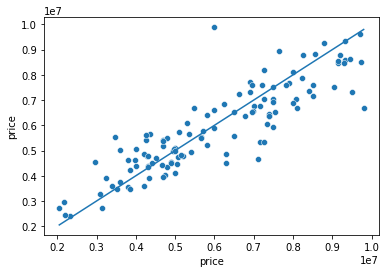

In [21]:
import seaborn as sns

sns.scatterplot(x=y_test,y=y_pred)
sns.lineplot(x=y_test, y=y_test)

<AxesSubplot:>

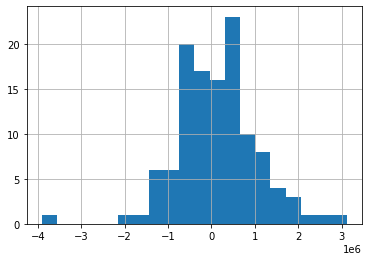

In [97]:
(y_test-y_pred).hist(bins=20)

## Сохранение модели

In [22]:
import pickle 
print(pickle.format_version)

4.0


In [24]:
model_pkl_file = "models/apartment_prices_regression.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(pipe, file)

In [25]:
import sklearn

sklearn.__version__

'1.2.2'